# Final Function

### Load Packages

In [1]:
import pandas as pd
import numpy as np
import sys
import re
import io
from shapely import wkt
import geckodriver_autoinstaller
import folium
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import interact,interact_manual,HBox,Output,Tab,widgets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
# Adapt accordingly https://pypi.org/project/webdriver-manager/
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from webdriver_manager.firefox import GeckoDriverManager
driver = webdriver.Firefox(service=Service(executable_path=GeckoDriverManager().install()))

[WDM] - Downloading: 16.2kB [00:00, 13.5MB/s]                   


### Specify model to be used

In [12]:
# Load Model to be used
model_name = "PSPNet_sm_Aug-04-2022-1349"
#model_name = "Linknet_sm_Aug-05-2022-1454"
#model_name = "Linknet_sm_Aug-07-2022-1853"

from keras.models import load_model
model = load_model(f"models/{model_name}.hdf5", compile=False)

### Define necessary functions

In [4]:
# Get image file
def make_map(pt, ts, size=640):
    """
    create folium map with a given center, 
    optionally fit and show a geometry and/or a larger bounding box
    """
    #pt = (pt[1], pt[0])

    # Create satellite image map for the coordinate point specified
    m = folium.Map(location=pt, min_zoom=17, max_zoom=18, width=size, height=size, zoom_control=False, attribution_control=False)
    
    # First tile server
    if ts == 1:
        folium.TileLayer(
            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr = 'Esri', name = 'Esri Satellite', overlay = False, control = True
        ).add_to(m)
    
    # Second tile server
    elif ts == 2:
        folium.TileLayer(
            tiles = 'https://clarity.maptiles.arcgis.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr = 'Esri', name = 'Esri Satellite', overlay = False, control = True
        ).add_to(m)
        
    #m.fit_bounds(bounds, max_zoom = 18)
    #m.fit_bounds(crop_bounds) # FLAG
    
    img_data = m._to_png()
    img = Image.open(io.BytesIO(img_data))
    
    img_size = (0,0,size,size)
    img = img.crop(img_size)
    rgb_im = img.convert("RGB")
    image = np.array(rgb_im)
    img2 = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    return img2

In [5]:
# Predict on a loaded image
def get_prediction(gps):
    test_img = make_map(gps, 2, 480)
    
    test_img_input = np.expand_dims(test_img, 0)

    prediction = (model.predict(test_img_input, verbose=0))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    #return predicted_img
    plt.figure(figsize=(10, 10))

    #plt.title('Prediction')
    plt.imshow(test_img)

    col_a = np.array([(0.1, 0.2, 0.5, 0), "yellow"], dtype=object)
    cmap_c = ListedColormap(col_a)

    plt.imshow(predicted_img, cmap=cmap_c, alpha=0.3)
    plt.axis('off')
    plt.show()

In [6]:
def check_coord_format(tup):
    try:
        float(tup[0])
    except: raise Exception("Wrong format for latitude. Input must be a decimal number with a dot as seperator")
    try:
        float(tup[1])
    except: raise Exception("Wrong format for longitude. Input must be a decimal number with a dot as seperator")

    if len(str(tup[0])) < 6 or len(str(tup[1])) < 6:
        raise Exception("Longitude or latitude too inprecise")

In [7]:
# Some parking lot locations for testing
# Get others from: https://www.openstreetmap.org/#map=19/48.11447/14.66582&layers=D
gps_directory = {0: (-17.9495555, 25.8216612), 
                 1: (-37.5922341, 144.2417904),
                 2: (-32.2087314, 148.6231326),
                 3: (51.6758745, 7.0868117),
                 4: (48.16320, 16.00519),        # Ab hier Google Earth (Westautobahn Wien)
                 5: (48.14587, 14.87352),
                 6: (48.11447, 14.66582),
                 7: (48.18516, 15.79659),
                 8: (48.13867, 14.58055),
                 9: (48.03200, 16.33646),
                 10:(51.08679, 13.2736163),
                 11:(48.03120, 16.33633),
                 100:(48.139, 14.581),
                 }

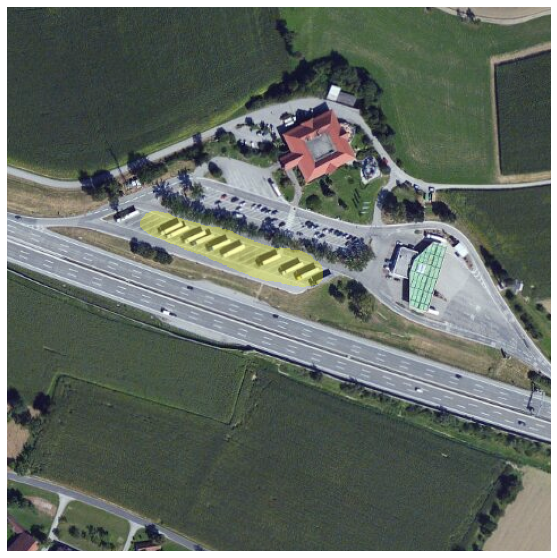

In [19]:
get_prediction(gps_directory[6])

### Final Interactive Function to get Predictions from coordinates

In [16]:
# Interactive Function for Predictions
display(widgets.HTML(
    value="<b>Get predictions on custom coordinates or for random parking lot positions</b> <br> \
    Get other coordinates from <a href=\"https://www.openstreetmap.org/\">OpenStreetMap</a> URL <br> \
    Getting a prediction can take up to 15 sec",
    placeholder='Some HTML',
))


#print("Generate Prediction for Custom Coordinates")
interact_generate = interact_manual.options(manual_name="Get Prediction")
@interact_generate(latitude="48.13867", longitude="14.58055")

def inter_pred(latitude, longitude):
    check_coord_format((latitude, longitude))
    gps = (float(latitude), float(longitude))
    return get_prediction(gps)


interact_random = interact_manual.options(manual_name="Random Parking Lot")
@interact_random()

def set_values():
    gps_r = gps_directory[np.random.randint(4,12)]
    lt_r = str(gps_r[0])
    lg_r = str(gps_r[1])
    return inter_pred(lt_r, lg_r)

HTML(value='<b>Get predictions on custom coordinates or for random parking lot positions</b> <br>     Get othe…

interactive(children=(Text(value='48.13867', description='latitude'), Text(value='14.58055', description='long…

interactive(children=(Button(description='Random Parking Lot', style=ButtonStyle()), Output()), _dom_classes=(…